# Exploring shape files

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from shapely.geometry import Polygon

- Bpn_CaPa: Property shape
- Bpn_ReBu: Detailed buildings
- Bpn_CaBl: Blocks
- Bpn_CaBu: Villages

# Open .shp with geopandas 

In [2]:
shapefile = gpd.read_file("/home/becode/Projects/3D_House/Shapes/ANTWERPEN_L72_2020/Bpn_ReBu.shp")

(180407, 12)


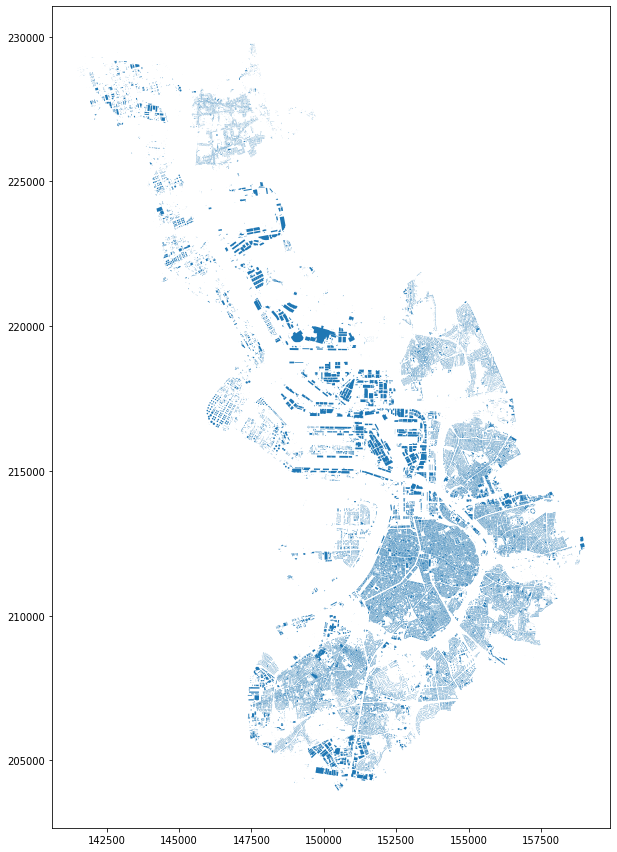

In [3]:
print(shapefile.shape)
shapefile.plot(figsize=(10,20))

# Find the center of a polygon

In [4]:
def center(poly:Polygon):
    return(int(poly.bounds[0]+poly.bounds[2]-poly.bounds[0]),
           int(poly.bounds[1]+poly.bounds[3]-poly.bounds[1]))

# Polygon properties

In [5]:
poly = shapefile.iloc[0].geometry
print(f"area: {poly.area}")
print(f"length: {poly.length}")
print(f"bounds: {poly.bounds}")
print(f"center: {center(poly)}")

area: 1528.8635578636026
length: 315.8299483118578
bounds: (145303.78720873446, 221262.07196570374, 145406.42456335557, 221313.50481525157)
center: (145406, 221313)


# Box class

In [6]:
class Box:
    def __init__(self, bounds=None, left:int=0, bottom:int=0, right:int=0, top:int=0):
        if bounds is not None: self.left,self.bottom,self.right,self.top = bounds
        else: self.left,self.bottom,self.right,self.top = left,bottom,right,top
        self.width, self.height = self.right -self.left, self.top -self.bottom
    def __str__(self):
        return "left:{} bottom:{} right:{} top:{} width:{} height:{}".format(
            self.left, self.bottom, self.right, self.top, self.width, self.height)
    def in_bounds(self, x:int, y:int) -> bool:
        return self.left < x < self.right and self.bottom < y < self.top

# Open The Beacon .tif

In [7]:
k15_subs = pd.read_csv("./bounds.csv", sep="|")
beacon_data = k15_subs[k15_subs.Name == "k15_1_2_1_1_0"]
beacon_box = Box(left=int(beacon_data.Left), bottom=int(beacon_data.Bottom),
                 right=int(beacon_data.Right), top=int(beacon_data.Top))
beacon_path = beacon_data.File.values[0]
beacon_tif = rio.open(beacon_path)

In [8]:
#beacon_tif = rio.open("./crop.tif")
#beacon_box = Box(left=int(beacon_tif.bounds.left), bottom=int(beacon_tif.bounds.bottom),
#                 right=int(beacon_tif.bounds.right), top=int(beacon_tif.bounds.top))

# Find all the shapes from gdf that are inside the tif.bounds

In [9]:
def get_shapes_in_box(gdf: GeoDataFrame, box: Box) -> GeoDataFrame:
    return gdf[gdf.geometry.apply(
        lambda d: box.in_bounds(
            x = center(Polygon(d))[0],
            y = center(Polygon(d))[1]
        ))]

# Plot shapes on top of tif with random colors

(72, 10)


/home/becode/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


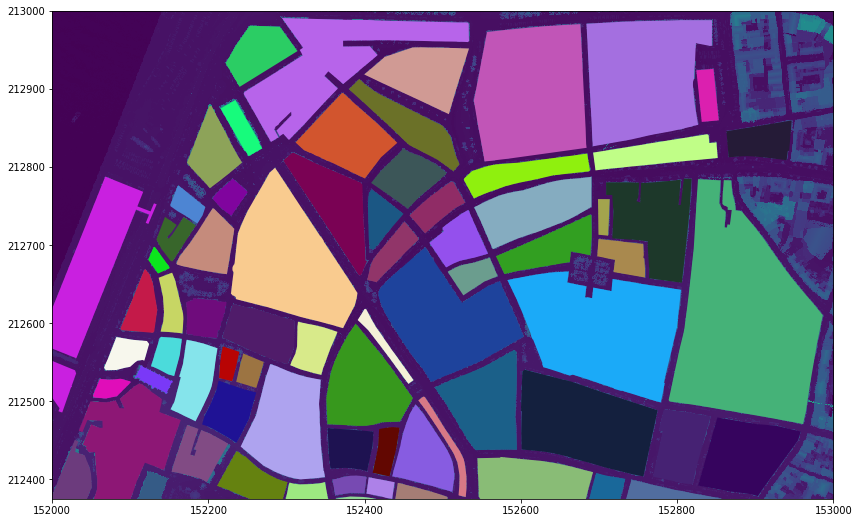

In [10]:
beacon_shapes = get_shapes_in_box(shapefile, beacon_box)
print(beacon_shapes.shape)

import random
beacon_shapes["color"] = [
    (random.random(), random.random(), random.random())
    for i in range(len(beacon_shapes))
]

beacon_shapes.plot(figsize=(14,14), color=beacon_shapes["color"])
show(beacon_tif)

In [11]:
beacon_shapes = beacon_shapes.drop("color", axis=1)

In [12]:
beacon_shapes.to_file("./beacon_shapes.shp")